In [20]:
import matplotlib.pyplot as plt
import torch
import cv2
import os
import random
from torchvision import transforms
import numpy as np
from easydict import EasyDict
from utils.datasets import letterbox
from utils.general import non_max_suppression, scale_coords, xyxy2xywh, check_img_size
from utils.plots import plot_one_box
from utils.torch_utils import select_device, TracedModel
from utils.datasets import LoadStreams, LoadImages
from models.experimental import attempt_load

1. opt参数，用edict实现，分别为：
   - conf_thres：置信度阈值，nms用，低于这个置信度的检测结果直接不要
   - iou_thres：IoU阈值，同样是nms用，用于筛掉IoU过低的
   - classes：nms的实现相关，不重要
   - agnostic_nms：做类别无关的nms
   - save_conf：不重要
   - img_size：训练的时候rescale到的大小
   - augment：数据增强
2. save_txt：保存检测结果成txt，save_img：保存画了bbox的图片

In [34]:
opt = EasyDict()
# 参照 detect.py 的默认值
opt.conf_thres = 0.15
opt.iou_thres = 0.45
opt.classes = None
opt.agnostic_nms = False # class-agnostic NMS
opt.save_conf = True
opt.img_size = 1280
opt.augment = False

save_txt = False
save_img = True
view_img = True

模型加载，注意修改路径；
- 本文件最好置于`*\yolov7\`文件夹下，否则需要改input的内容

In [35]:
torch.no_grad()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weights = './runs/train/yolov7-w6-2303-all/weights/best.pt'
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(opt.img_size, s=stride)  # check img_size
model = TracedModel(model, device, opt.img_size)
model.half()  # to FP16

# 数据集&可视化相关
names = model.module.names if hasattr(model, 'module') else model.names
colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
names, colors

Fusing layers... 
IAuxDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



(['ycrane', 'forklift', 'wcrane', 'car', 'crane arm'],
 [[45, 129, 216],
  [188, 149, 142],
  [239, 63, 219],
  [19, 182, 199],
  [103, 150, 7]])

- source：数据源，[文件夹路径，视频/图片文件路径]
- output_dir：检测结果和可视化结果的输出文件夹

In [36]:
source = './inference/guangzhou-2303/2303-err'
output_dir = './inference/guangzhou-2303/output'

dataset = LoadImages(source, img_size=imgsz, stride=stride)
if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
old_img_w = old_img_h = imgsz
old_img_b = 1

In [37]:
for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img.half()    # uint8 to fp16
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Warmup
    if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
        old_img_b = img.shape[0]
        old_img_h = img.shape[2]
        old_img_w = img.shape[3]
        for i in range(3):
            model(img, augment=opt.augment)[0]
            
    # Inference
    with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
        pred = model(img, augment=opt.augment)[0]
    # NMS
    pred_nms = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)

    for i, det in enumerate(pred_nms):  # detections per image, 实际上只有一张图
        p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)
        save_path = os.path.join(output_dir, os.path.split(p)[1])
        txt_path = os.path.join(output_dir, os.path.split(p)[1].split('.')[0]+'.txt')
        img_show = im0.copy()
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        s = ''  # 输出字串
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
            # Print results
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()  # detections per class
                s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
            # Write results
            for *xyxy, conf, cls in reversed(det):
                xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                if int(cls) != 4:
                    # 不是吊臂，则输出bbox下边缘中点
                    print([float((xyxy[0]+xyxy[2])/2), float(xyxy[3])])
                else:
                    # 是吊臂，则
                    crane_arm = im0[int(xyxy[1]):int(xyxy[3]),int(xyxy[0]):int(xyxy[2])]    # 截取原图的吊臂部分
                if save_txt:  # Write to file
                    line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                    with open(txt_path + '.txt', 'a') as f:
                        f.write(('%g ' * len(line)).rstrip() % line + '\n')
                if save_img or view_img:  # Add bbox to image
                    label = f'{names[int(cls)]} {conf:.2f}'
                    plot_one_box(xyxy, img_show, label=label, color=colors[int(cls)], line_thickness=1)
        print(s)
        cv2.imwrite(save_path, img_show)

[7.0, 103.0]
[420.0, 126.0]
[433.5, 126.0]

[476.0, 302.0]
1 wcrane, 3 cars, 1 crane arm, 
[1344.0, 402.0]

[1630.0, 966.0]
[1387.0, 404.0]
1 wcrane, 2 cars, 1 crane arm, 

[886.5, 848.0]
[961.5, 749.0]
[650.0, 1826.0]
1 ycrane, 1 forklift, 1 car, 1 crane arm, 
[1344.0, 401.0]
[1782.0, 1680.0]

[1501.0, 605.0]
[1387.0, 404.0]
1 wcrane, 3 cars, 1 crane arm, 
[1460.0, 488.0]
[1343.0, 401.0]
[1447.0, 620.0]

[1402.0, 446.0]
[1500.0, 607.0]
[1713.0, 1382.0]
[1386.0, 404.0]
1 ycrane, 1 forklift, 5 cars, 1 crane arm, 
[1344.0, 401.0]
[1402.0, 446.0]

[1526.0, 739.0]
[2027.5, 1918.0]
[1387.0, 404.0]
1 ycrane, 1 forklift, 3 cars, 1 crane arm, 

[969.0, 878.0]
[650.0, 1824.0]
1 wcrane, 1 car, 1 crane arm, 

[985.5, 1138.0]
1 wcrane, 1 crane arm, 

[874.0, 1137.0]
1 wcrane, 1 crane arm, 

[952.0, 946.0]
[861.0, 1692.0]
[651.0, 1825.0]
1 ycrane, 1 forklift, 1 car, 1 crane arm, 

[861.5, 1693.0]
[954.5, 945.0]
[650.0, 1826.0]
1 ycrane, 1 forklift, 1 car, 1 crane arm, 
[957.5, 749.0]
[887.0, 849.0]

FP32精度的，自己加载数据，写了一版，没用API

In [6]:
torch.no_grad()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weights = './runs/train/yolov7-w6-2303-all/weights/best.pt'
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(opt.img_size, s=stride)  # check img_size
model = TracedModel(model, device, opt.img_size)

im0 = cv2.imread('./inference/guangzhou-2303/P23031014583810.jpg')  # 1920*2560
# im0 = cv2.imread('./inference/guangzhou-2303/2303-err/202304161317071.jpg')
im_background = cv2.imread('./inference/guangzhou-2303/P23031017142610.jpg')
img_show = im0.copy()     # 可视化bbox用
img = letterbox(im0, 1280, stride=64, auto=True)[0]
img_ = img.copy()
img = transforms.ToTensor()(img_)
img = torch.tensor(np.array([img.numpy()]))
img = img.to(device)
# image = image.half()

pred = model(img)[0]
pred_nms = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)

for i, det in enumerate(pred_nms):  # detections per image, 实际上只有一张图
    save_path = './inference/guangzhou-2303/output.jpg'
    txt_path = './inference/guangzhou-2303/output.txt'
    fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()   # 背景差分
    _ = fgbg.apply(im_background)
    fgbgmask = fgbg.apply(im0)
    # im0_mask = np.empty_like(im0)
    # im0_mask[:,:,0] = fgbgmask
    # im0_mask[:,:,1] = fgbgmask
    # im0_mask[:,:,2] = fgbgmask
    # print(im0_mask.shape)
    gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
    s = ''  # 输出字串
    if len(det):
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape[:2]).round()
        # Print results
        for c in det[:, -1].unique():
            n = (det[:, -1] == c).sum()  # detections per class
            s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
        # Write results
        for *xyxy, conf, cls in reversed(det):
            xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
            if int(cls) != 4:
                # 不是吊臂，则输出bbox下边缘中点
                print([float((xyxy[0]+xyxy[2])/2), float(xyxy[3])])
            else:
                # 是吊臂，则截取mask的吊臂部分，做霍夫变换检测线段，根据线段方向投票判断朝向
                crane_arm = fgbgmask[int(xyxy[1]):int(xyxy[3]),int(xyxy[0]):int(xyxy[2])]
                lines = cv2.HoughLinesP(crane_arm, 1.0, np.pi/180, 200, minLineLength=50, maxLineGap=5)
                cnt1 = 0    # 向左上右下
                cnt2 = 0    # 向左下右上
                for line in lines:
                    x1, y1, x2, y2 = line.reshape(4)
                    if (x1-x2)*(y1-y2) > 0:
                        cnt1 += 1
                    else:
                        cnt2 += 1
                # 输出 [吊臂顶端点, 吊臂底端点]
                if cnt1 > cnt2:
                    # 向左上右下
                    print([float(xyxy[0]),float(xyxy[1]),float(xyxy[2]),float(xyxy[3])])
                else:
                    # 向左下右上
                    print([float(xyxy[2]),float(xyxy[1]),float(xyxy[0]),float(xyxy[3])])
            if save_txt:  # Write to file
                line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                with open(txt_path + '.txt', 'a') as f:
                    f.write(('%g ' * len(line)).rstrip() % line + '\n')
            if save_img or view_img:  # Add bbox to image
                label = f'{names[int(cls)]} {conf:.2f}'
                plot_one_box(xyxy, img_show, label=label, color=colors[int(cls)], line_thickness=1)
    print(s)
    cv2.imwrite(save_path, img_show)

[1343.5, 401.0]
[1386.5, 403.0]
[1628.5, 964.0]
1 wcrane, 2 cars, 


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

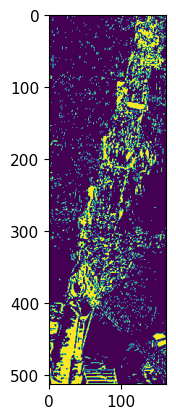

In [156]:
plt.imshow(crane_arm)

In [163]:
# tmp = cv2.Canny(crane_arm, 240, 255)
lines = cv2.HoughLinesP(crane_arm, 1.0, np.pi/180, 200, minLineLength=50, maxLineGap=5)
lines.shape

(28, 1, 4)

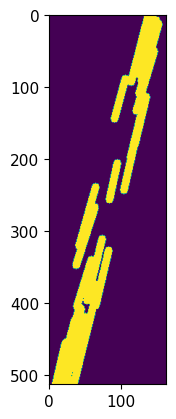

In [162]:
tmp = np.zeros_like(crane_arm)
for line in lines:
    x1, y1, x2, y2 = line.reshape(4)
    cv2.line(tmp, (x1,y1), (x2,y2),255,10)
plt.imshow(tmp)

判断吊臂方向那里，还需要调参！或者有没有更好的实现？